# Gillian Tatreau
# 19 November 2022

## General Set up

In [1]:
# import packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from distfit import distfit
import scipy.stats as ss
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# create dataframe and view data
df = pd.read_csv("Food_Production.csv")
df.head

<bound method NDFrame.head of            Food product  Land use change  Animal Feed  Farm  Processing  \
0   Wheat & Rye (Bread)              0.1          0.0   0.8         0.2   
1          Maize (Meal)              0.3          0.0   0.5         0.1   
2         Barley (Beer)              0.0          0.0   0.2         0.1   
3               Oatmeal              0.0          0.0   1.4         0.0   
4                  Rice              0.0          0.0   3.6         0.1   
5              Potatoes              0.0          0.0   0.2         0.0   
6               Cassava              0.6          0.0   0.2         0.0   
7            Cane Sugar              1.2          0.0   0.5         0.0   
8            Beet Sugar              0.0          0.0   0.5         0.2   
9          Other Pulses              0.0          0.0   1.1         0.0   
10                 Peas              0.0          0.0   0.7         0.0   
11                 Nuts             -2.1          0.0   2.1         0.

In [3]:
# list of column names, to choose variables to focus on
df.columns

Index(['Food product', 'Land use change', 'Animal Feed', 'Farm', 'Processing',
       'Transport', 'Packging', 'Retail', 'Total_emissions',
       'Eutrophying emissions per 1000kcal (gPO₄eq per 1000kcal)',
       'Eutrophying emissions per kilogram (gPO₄eq per kilogram)',
       'Eutrophying emissions per 100g protein (gPO₄eq per 100 grams protein)',
       'Freshwater withdrawals per 1000kcal (liters per 1000kcal)',
       'Freshwater withdrawals per 100g protein (liters per 100g protein)',
       'Freshwater withdrawals per kilogram (liters per kilogram)',
       'Greenhouse gas emissions per 1000kcal (kgCO₂eq per 1000kcal)',
       'Greenhouse gas emissions per 100g protein (kgCO₂eq per 100g protein)',
       'Land use per 1000kcal (m² per 1000kcal)',
       'Land use per kilogram (m² per kilogram)',
       'Land use per 100g protein (m² per 100g protein)',
       'Scarcity-weighted water use per kilogram (liters per kilogram)',
       'Scarcity-weighted water use per 100g protein 

In [4]:
# new data frame that renames chosen variables to be easier to use
df2 = df.rename(columns={"Food product" : "food", "Total_emissions" : "total_em", 
                         "Eutrophying emissions per 1000kcal (gPO₄eq per 1000kcal)" : "eutro_kcal", 
                         "Eutrophying emissions per 100g protein (gPO₄eq per 100 grams protein)" : "eutro_protein",
                         "Greenhouse gas emissions per 1000kcal (kgCO₂eq per 1000kcal)" : "greenhouse_kcal",
                         "Greenhouse gas emissions per 100g protein (kgCO₂eq per 100g protein)" : "greenhouse_protein",
                         "Land use per 1000kcal (m² per 1000kcal)" : "land_kcal",
                         "Land use per 100g protein (m² per 100g protein)" : "land_protein",
                         "Scarcity-weighted water use per 1000kcal (liters per 1000 kilocalories)" : "water_kcal",
                         "Scarcity-weighted water use per 100g protein (liters per 100g protein)" : "water_protein"})
                         

In [5]:
# name of columns, with new names of chosen variables
df2.columns

Index(['food', 'Land use change', 'Animal Feed', 'Farm', 'Processing',
       'Transport', 'Packging', 'Retail', 'total_em', 'eutro_kcal',
       'Eutrophying emissions per kilogram (gPO₄eq per kilogram)',
       'eutro_protein',
       'Freshwater withdrawals per 1000kcal (liters per 1000kcal)',
       'Freshwater withdrawals per 100g protein (liters per 100g protein)',
       'Freshwater withdrawals per kilogram (liters per kilogram)',
       'greenhouse_kcal', 'greenhouse_protein', 'land_kcal',
       'Land use per kilogram (m² per kilogram)', 'land_protein',
       'Scarcity-weighted water use per kilogram (liters per kilogram)',
       'water_protein', 'water_kcal'],
      dtype='object')

## Creating Scenarios: all food products, vegetarian food products, vegan food products

In [6]:
# creating variables to use: df2 will have all food products, 
# veg will have vegetarian food products (including eggs etc that are animal products but not meat), 
# and vegan which excludes all animal products entirely
all_animal = df2.index.isin([33, 34, 35, 36, 37, 38, 39, 40, 41, 42])
animal_veg = df2.index.isin([33, 35, 36, 37, 41, 42])
veg = df2[~animal_veg]
vegan = df2[~all_animal]

## Explanation of variables

- **food** is the food product
- **total_em** is the total emissions of greenhouse gas per kg of food product(Kg CO2) totaled over every aspect of food production (total emissions of greenhouse gas omitted by producing the food item)
- **eutro_kcal** is the measure of eutrophication (which is caused by land runoff during production) measured in g PO equivalent per 1000 Calories for each food product
- **eutro_protein** is the measure of eutrophication measured in g PO equivalent per 100 g of protein for each food product
- **greenhouse_kcal** is the greenhouse gas emissions (kg CO2 equivalent) per 1000 Calories for each food product
- **greenhouse_protein** is the greenhouse gas emissions (kg CO2 equivalent) per 100 g of protein for each food product
- **land_kcal** is the land used in production of each food product, measured in m2 per 1000 Calories of food
- **land_protein** is the land used in production of each food product, measured in m2 per 100 g of protein in each food product
- **water_kcal** is the amount of water used in production of each food product, weighted for water scarcity, measured in liters per 1000 Calories of food
- **water_protein** is the amount of water used in production of each food product, weighted for water scarcity, measured in liters per 100 g of protein in each food product

## Descriptive stats and histograms of chosen variables

In [7]:
# function to calculate optimal bin width and number of bins for each variable
def bin_count(column, data):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    bin_width = (2 * iqr) / (len(column) ** (1 / 3))
    binnum = int(np.ceil((column.max() - column.min()) / bin_width))
    print(binnum, bin_width)

In [8]:
# outlier function
def outlier(column, data):
    f = data.food
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)

    IQR = Q3 - Q1
    
    outlier_name = f[((column<(Q1-1.5*IQR))|(column>(Q3+1.5*IQR)))]
    
    outlier_val = column[((column<(Q1-1.5*IQR))|(column>(Q3+1.5*IQR)))]
    
    outliers = pd.concat([outlier_name, outlier_val], axis=1)
    
    print(outliers)

### total_em

21 2.940002769443513
count    43.000000
mean      5.972093
std      10.501753
min       0.200000
25%       0.850000
50%       1.600000
75%       6.000000
max      59.600000
Name: total_em, dtype: float64 
Number of Na's:  0


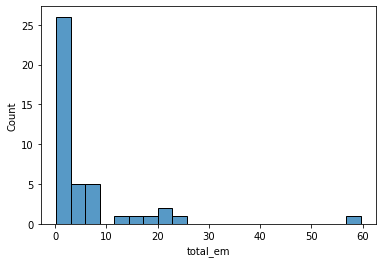

In [9]:
bin_count(df2.total_em, df2)
sns.histplot(data=df2, x="total_em", bins = 21)
print(df2.total_em.describe(), "\nNumber of Na's: ", df2.total_em.isna().sum())

                 food  total_em
31             Coffee      16.5
32     Dark Chocolate      18.7
33   Beef (beef herd)      59.6
34  Beef (dairy herd)      21.1
35      Lamb & Mutton      24.5
39             Cheese      21.2


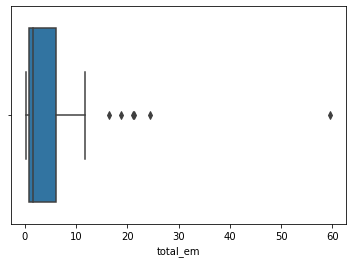

In [10]:
sns.boxplot(data=df2, x="total_em")
outlier(df2.total_em, df2)

### eutro_kcal

16 12.621684325851025
count     33.000000
mean      27.181547
std       46.445959
min        0.708419
25%        4.214932
50%        7.000000
75%       26.324324
max      197.357143
Name: eutro_kcal, dtype: float64 
Number of Na's:  10


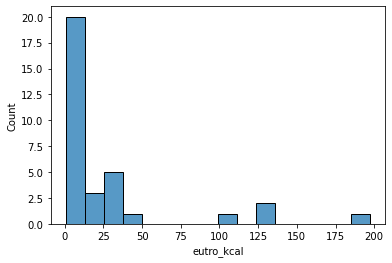

In [11]:
bin_count(df2.eutro_kcal, df2)
sns.histplot(data=df2, x="eutro_kcal", bins = 16)
print(df2.eutro_kcal.describe(), "\nNumber of Na's: ", df2.eutro_kcal.isna().sum())

                 food  eutro_kcal
31             Coffee  197.357143
33   Beef (beef herd)  110.406593
34  Beef (dairy herd)  133.805861
41      Fish (farmed)  131.351955


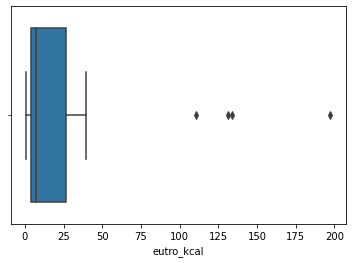

In [12]:
sns.boxplot(data=df2, x="eutro_kcal")
outlier(df2.eutro_kcal, df2)

### eutro_protein

9 21.374589583957793
count     27.000000
mean      52.771953
std       52.033823
min        3.384338
25%       17.855335
50%       37.333333
75%       55.297183
max      185.050659
Name: eutro_protein, dtype: float64 
Number of Na's:  16


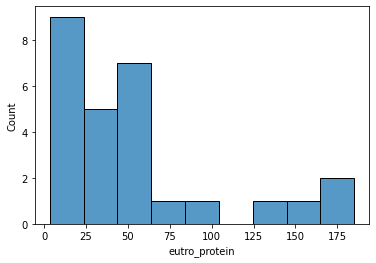

In [13]:
bin_count(df2.eutro_protein, df2)
sns.histplot(data=df2, x="eutro_protein", bins = 9)
print(df2.eutro_protein.describe(), "\nNumber of Na's: ", df2.eutro_protein.isna().sum())

                 food  eutro_protein
31             Coffee     138.150000
32     Dark Chocolate     174.160000
33   Beef (beef herd)     151.158475
34  Beef (dairy herd)     185.050659


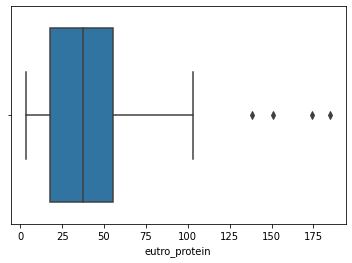

In [14]:
sns.boxplot(data=df2, x="eutro_protein")
outlier(df2.eutro_protein, df2)

### greenhouse_kcal

19 2.6869455042630506
count    33.000000
mean      5.633943
std      10.613575
min       0.069919
25%       0.628415
50%       1.351351
75%       5.335135
max      50.946429
Name: greenhouse_kcal, dtype: float64 
Number of Na's:  10


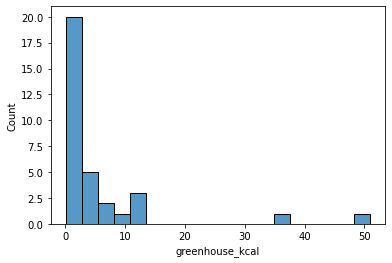

In [15]:
bin_count(df2.greenhouse_kcal, df2)
sns.histplot(data=df2, x="greenhouse_kcal", bins = 19)
print(df2.greenhouse_kcal.describe(), "\nNumber of Na's: ", df2.greenhouse_kcal.isna().sum())

                food  greenhouse_kcal
31            Coffee        50.946429
33  Beef (beef herd)        36.439560
35     Lamb & Mutton        12.529968


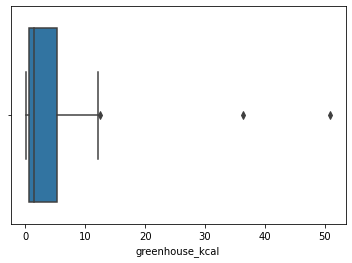

In [16]:
sns.boxplot(data=df2, x="greenhouse_kcal")
outlier(df2.greenhouse_kcal, df2)

### greenhouse_protein

15 6.254438856879786
count    27.000000
mean     13.524906
std      19.427462
min       0.263319
25%       4.027439
50%       6.500000
75%      14.983333
max      93.300000
Name: greenhouse_protein, dtype: float64 
Number of Na's:  16


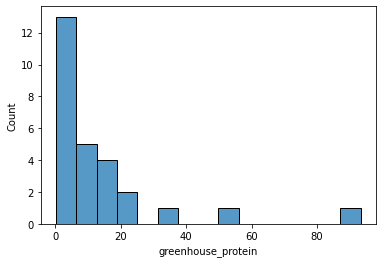

In [17]:
bin_count(df2.greenhouse_protein, df2)
sns.histplot(data=df2, x="greenhouse_protein", bins = 15)
print(df2.greenhouse_protein.describe(), "\nNumber of Na's: ", df2.greenhouse_protein.isna().sum())

                food  greenhouse_protein
31            Coffee           35.662500
32    Dark Chocolate           93.300000
33  Beef (beef herd)           49.889669


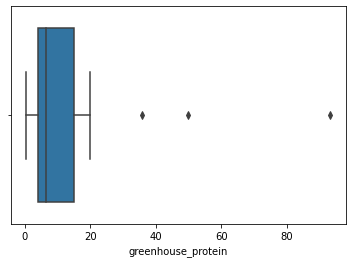

In [18]:
sns.boxplot(data=df2, x="greenhouse_protein")
outlier(df2.greenhouse_protein, df2)

### land_kcal

40 3.0215837959422407
count     33.000000
mean      12.423165
std       28.348693
min        0.273756
25%        1.312500
50%        2.976244
75%        6.605405
max      119.490842
Name: land_kcal, dtype: float64 
Number of Na's:  10


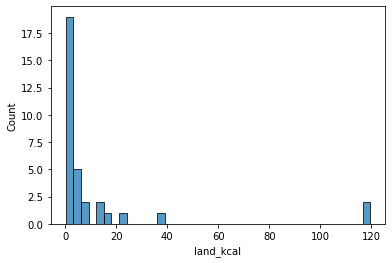

In [19]:
bin_count(df2.land_kcal, df2)
sns.histplot(data=df2, x="land_kcal", bins = 40)
print(df2.land_kcal.describe(), "\nNumber of Na's: ", df2.land_kcal.isna().sum())

                 food   land_kcal
31             Coffee   38.607143
33   Beef (beef herd)  119.490842
34  Beef (dairy herd)   15.838828
35      Lamb & Mutton  116.659306
38               Milk   14.916667
39             Cheese   22.684755


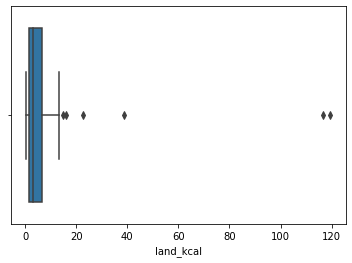

In [20]:
sns.boxplot(data=df2, x="land_kcal")
outlier(df2.land_kcal, df2)

### land_protein

18 10.226725794340677
count     27.000000
mean      29.105042
std       49.307339
min        3.000000
25%        5.088235
50%        7.936314
75%       23.002381
max      184.812594
Name: land_protein, dtype: float64 
Number of Na's:  16


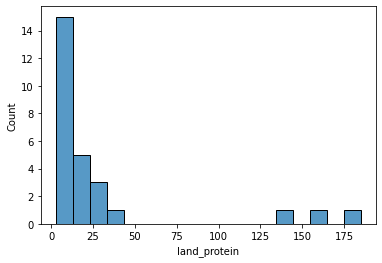

In [21]:
bin_count(df2.land_protein, df2)
sns.histplot(data=df2, x="land_protein", bins = 18)
print(df2.land_protein.describe(), "\nNumber of Na's: ", df2.land_protein.isna().sum())

                food  land_protein
32    Dark Chocolate    137.920000
33  Beef (beef herd)    163.595787
35     Lamb & Mutton    184.812594


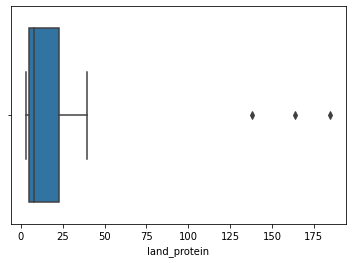

In [22]:
sns.boxplot(data=df2, x="land_protein")
outlier(df2.land_protein, df2)

### water_kcal

4 14321.722040903755
count       30.000000
mean     17380.575408
std      16232.080209
min          4.095023
25%       2969.124983
50%      12605.256790
75%      28056.471593
max      49735.882350
Name: water_kcal, dtype: float64 
Number of Na's:  13


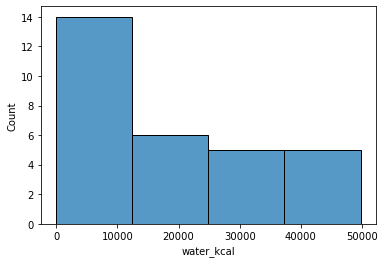

In [23]:
bin_count(df2.water_kcal, df2)
sns.histplot(data=df2, x="water_kcal", bins = 4)
print(df2.water_kcal.describe(), "\nNumber of Na's: ", df2.water_kcal.isna().sum())

Empty DataFrame
Columns: [food, water_kcal]
Index: []


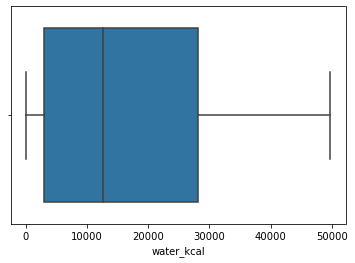

In [24]:
sns.boxplot(data=df2, x="water_kcal")
outlier(df2.water_kcal, df2)

### water_protein

13 34043.13126120608
count        26.000000
mean      59196.438503
std       89928.189299
min         421.250000
25%       11018.401008
50%       20917.213595
75%       70651.721023
max      431620.000000
Name: water_protein, dtype: float64 
Number of Na's:  17


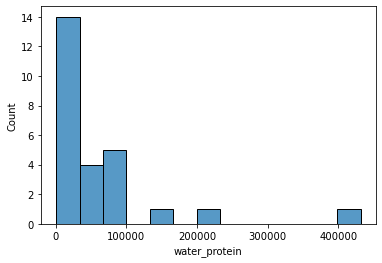

In [25]:
bin_count(df2.water_protein, df2)
sns.histplot(data=df2, x="water_protein", bins = 13)
print(df2.water_protein.describe(), "\nNumber of Na's: ", df2.water_protein.isna().sum())

                food  water_protein
27            Apples       431620.0
28  Berries & Grapes       211621.0


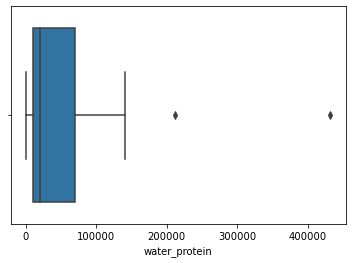

In [26]:
sns.boxplot(data=df2, x="water_protein")
outlier(df2.water_protein, df2)

## PMFs and CDFs

### water_kcal

<AxesSubplot:xlabel='water_kcal', ylabel='Count'>

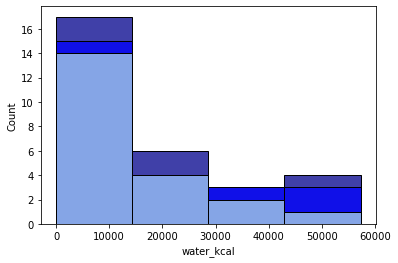

In [27]:
sns.histplot(data=df2, x="water_kcal", color = "darkblue", binwidth=14321.7)
sns.histplot(data=veg, x="water_kcal", color = "blue", binwidth=14321.7)
sns.histplot(data=vegan, x="water_kcal", color = "lightblue", binwidth=14321.7)

<AxesSubplot:xlabel='water_kcal', ylabel='Probability'>

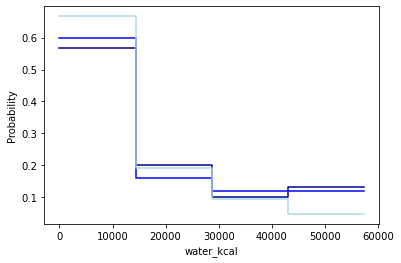

In [28]:
# pmf
sns.histplot(data=df2, x="water_kcal", color = "darkblue", stat = "probability", element = "step", fill = False, binwidth=14321.7)
sns.histplot(data=veg, x="water_kcal", color = "blue", stat = "probability", element = "step", fill = False, binwidth=14321.7)
sns.histplot(data=vegan, x="water_kcal", color = "lightblue", stat = "probability", element = "step", fill = False, binwidth=14321.7)

<AxesSubplot:xlabel='water_kcal', ylabel='Density'>

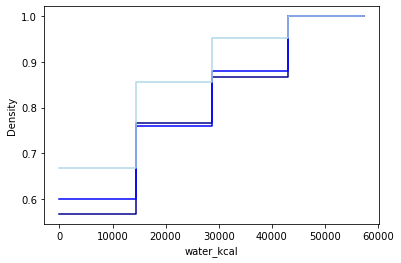

In [29]:
# cdf
sns.histplot(data=df2, x="water_kcal", element="step", fill=False, cumulative=True, stat="density", color = "darkblue", binwidth = 14321.7)
sns.histplot(data=veg, x="water_kcal", element="step", fill=False, cumulative=True, stat="density", color = "blue", binwidth = 14321.7)
sns.histplot(data=vegan, x="water_kcal", element="step", fill=False, cumulative=True, stat="density", color = "lightblue", binwidth = 14321.7)

It appear that vegan food products use less water in general than the other scenarios, with vegetarian products using less water in the first and third bins and more in the second. 

### total_em

<AxesSubplot:xlabel='total_em', ylabel='Count'>

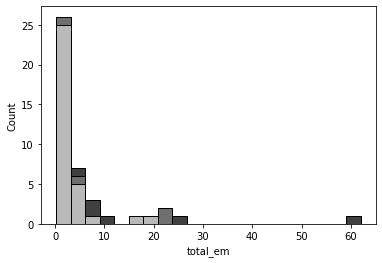

In [30]:
sns.histplot(data=df2, x="total_em", color = "black", binwidth = 2.94)
sns.histplot(data=veg, x="total_em", color = "grey", binwidth = 2.94)
sns.histplot(data=vegan, x="total_em", color = "lightgrey", binwidth = 2.94)

<AxesSubplot:xlabel='total_em', ylabel='Probability'>

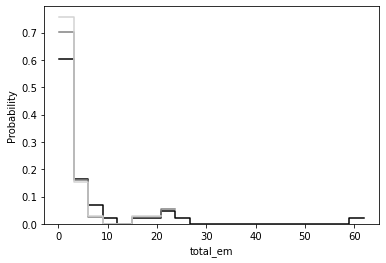

In [31]:
# pmf
sns.histplot(data=df2, x="total_em", color = "black", stat = "probability", element = "step", fill = False, binwidth = 2.94)
sns.histplot(data=veg, x="total_em", color = "grey", stat = "probability", element = "step", fill = False, binwidth = 2.94)
sns.histplot(data=vegan, x="total_em", color = "lightgrey", stat = "probability", element = "step", fill = False, binwidth = 2.94)

<AxesSubplot:xlabel='total_em', ylabel='Density'>

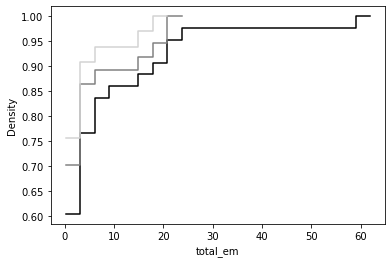

In [32]:
# cdf
sns.histplot(data=df2, x="total_em", element="step", fill=False, cumulative=True, stat="density", color = "black", binwidth = 2.94)
sns.histplot(data=veg, x="total_em", element="step", fill=False, cumulative=True, stat="density", color = "grey", binwidth = 2.94)
sns.histplot(data=vegan, x="total_em", element="step", fill=False, cumulative=True, stat="density", color = "lightgrey", binwidth = 2.94)

It appears that vegan food products produce fewer emissions during their production, followed by vegetarian products, then all food products. 

### eutro_protein

<AxesSubplot:xlabel='eutro_protein', ylabel='Count'>

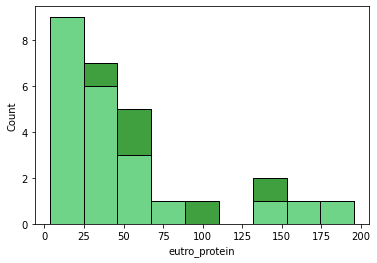

In [33]:
sns.histplot(data=df2, x="eutro_protein", binwidth = 21.37, color = "green")
sns.histplot(data=veg, x="eutro_protein", binwidth = 21.37, color = "teal")
sns.histplot(data=veg, x="eutro_protein", binwidth = 21.37, color = "lightgreen")

<AxesSubplot:xlabel='eutro_protein', ylabel='Probability'>

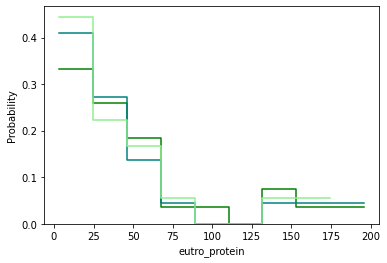

In [34]:
# pmf
sns.histplot(data=df2, x="eutro_protein", color = "green", stat = "probability", element = "step", fill = False, binwidth = 21.37)
sns.histplot(data=veg, x="eutro_protein", color = "teal", stat = "probability", element = "step", fill = False, binwidth = 21.37)
sns.histplot(data=vegan, x="eutro_protein", color = "lightgreen", stat = "probability", element = "step", fill = False, binwidth = 21.37)

<AxesSubplot:xlabel='eutro_protein', ylabel='Density'>

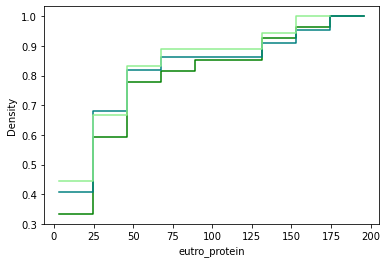

In [35]:
# cdf
sns.histplot(data=df2, x="eutro_protein", element="step", fill=False, cumulative=True, stat="density", color = "green", binwidth = 21.37)
sns.histplot(data=veg, x="eutro_protein", element="step", fill=False, cumulative=True, stat="density", color = "teal", binwidth = 21.37)
sns.histplot(data=vegan, x="eutro_protein", element="step", fill=False, cumulative=True, stat="density", color = "lightgreen", binwidth = 21.37)

In general, vegan food products produce less eutrophying emissions than the other scenarios; however, the difference betweenbetween all three (and especially between vegan and vegetarian) is much less noticable than in other variables. 

### greenhouse_protein

<AxesSubplot:xlabel='greenhouse_protein', ylabel='Count'>

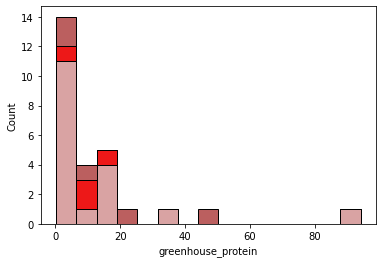

In [36]:
sns.histplot(data=df2, x="greenhouse_protein", color = "brown", binwidth = 6.25)
sns.histplot(data=veg, x="greenhouse_protein", color = "red", binwidth = 6.25)
sns.histplot(data=vegan, x="greenhouse_protein", color = "lightgrey", binwidth = 6.25)

<AxesSubplot:xlabel='greenhouse_protein', ylabel='Probability'>

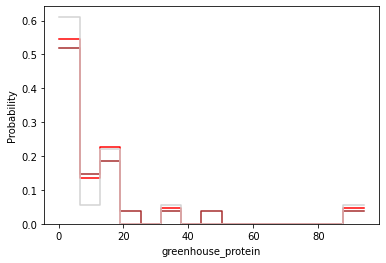

In [37]:
# pmf
sns.histplot(data=df2, x="greenhouse_protein", color = "brown", stat = "probability", element = "step", fill = False, binwidth = 6.25)
sns.histplot(data=veg, x="greenhouse_protein", color = "red", stat = "probability", element = "step", fill = False, binwidth = 6.25)
sns.histplot(data=vegan, x="greenhouse_protein", color = "lightgrey", stat = "probability", element = "step", fill = False, binwidth = 6.25)

<AxesSubplot:xlabel='greenhouse_protein', ylabel='Density'>

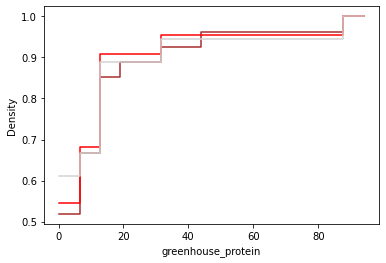

In [38]:
# cdf
sns.histplot(data=df2, x="greenhouse_protein", element="step", fill=False, cumulative=True, stat="density", color = "brown", binwidth = 6.25)
sns.histplot(data=veg, x="greenhouse_protein", element="step", fill=False, cumulative=True, stat="density", color = "red", binwidth = 6.25)
sns.histplot(data=vegan, x="greenhouse_protein", element="step", fill=False, cumulative=True, stat="density", color = "lightgrey", binwidth = 6.25)

For this variable, while the vegan food products start out with lower greenhouse gas emissions per 100g protein, the vegetarian food products are lower over the entire range, except for the very smallest emissions. 

## Plot of analytic distributions for chosen variables

In [39]:
# function to plot analytic distribution
def define_analytic(variable):
    x = variable.dropna()
    
    dist = distfit()
    
    dist.fit_transform(x)
    
    dist.plot()
    
    dist.plot_summary()
    
    print(dist.summary)

### total_em

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.101711] [loc=5.972 scale=10.379]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.0342422] [loc=0.200 scale=5.772]
[distfit] >[pareto    ] [0.08 sec] [RSS: 0.00540812] [loc=-2.023 scale=2.223]
[distfit] >[dweibull  ] [0.04 sec] [RSS: 0.0399319] [loc=1.100 scale=5.452]
[distfit] >[t         ] [0.03 sec] [RSS: 0.0123526] [loc=1.158 scale=0.947]
[distfit] >[genextreme] [0.07 sec] [RSS: 0.008662] [loc=1.110 scale=1.369]
[distfit] >[gamma     ] [0.08 sec] [RSS: 0.0232953] [loc=0.200 scale=12.639]
[distfit] >[lognorm   ] [0.13 sec] [RSS: 0.00584022] [loc=0.180 scale=1.719]
[distfit] >[beta      ] [0.13 sec] [RSS: 0.0376993] [loc=0.200 scale=95.288]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.124166] [loc=0.200 scale=59.400]
[distfit] >[loggamma  ] [0.08 sec] [RSS: 0.102152] [loc=-3784.087 scale=492.987]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..
[distfit] >plot summary..
         distr     

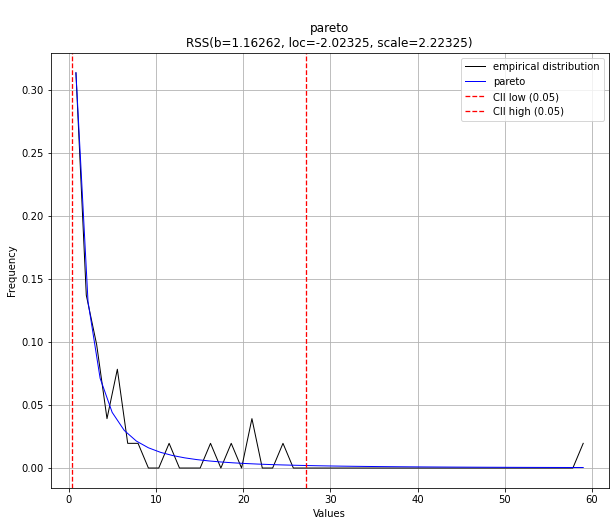

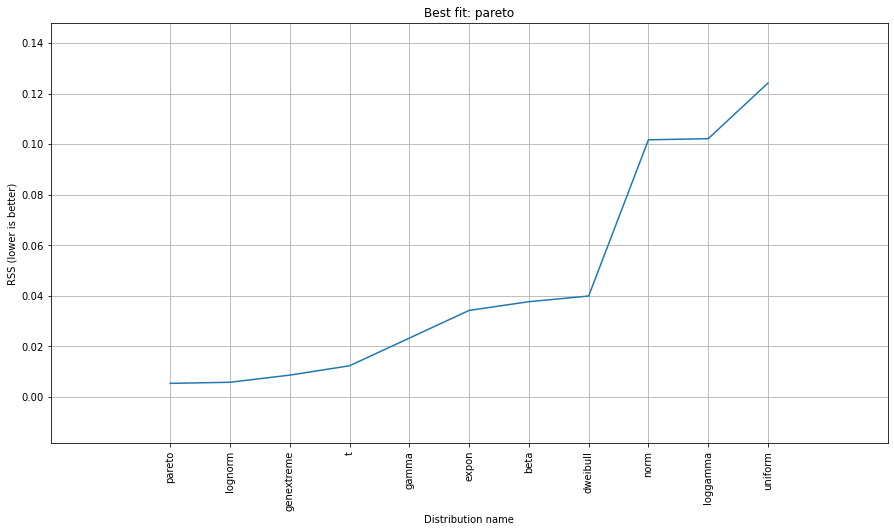

In [40]:
define_analytic(df2.total_em)

### eutro_kcal

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.00895471] [loc=27.182 scale=45.737]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.00406029] [loc=0.708 scale=26.473]
[distfit] >[pareto    ] [0.04 sec] [RSS: 0.0013207] [loc=-1.073 scale=1.781]
[distfit] >[dweibull  ] [0.04 sec] [RSS: 0.0056299] [loc=4.821 scale=38.150]
[distfit] >[t         ] [0.03 sec] [RSS: 0.00162381] [loc=4.444 scale=2.736]
[distfit] >[genextreme] [0.12 sec] [RSS: 0.00106831] [loc=5.104 scale=6.047]
[distfit] >[gamma     ] [0.06 sec] [RSS: 0.00279027] [loc=0.708 scale=88.478]
[distfit] >[lognorm   ] [0.05 sec] [RSS: 0.00100805] [loc=0.560 scale=8.216]
[distfit] >[beta      ] [0.11 sec] [RSS: 0.00489608] [loc=0.708 scale=271.206]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.0100457] [loc=0.708 scale=196.649]
[distfit] >[loggamma  ] [0.06 sec] [RSS: 0.00903339] [loc=-15689.019 scale=2082.818]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..
[distfit] >plot summary..
  

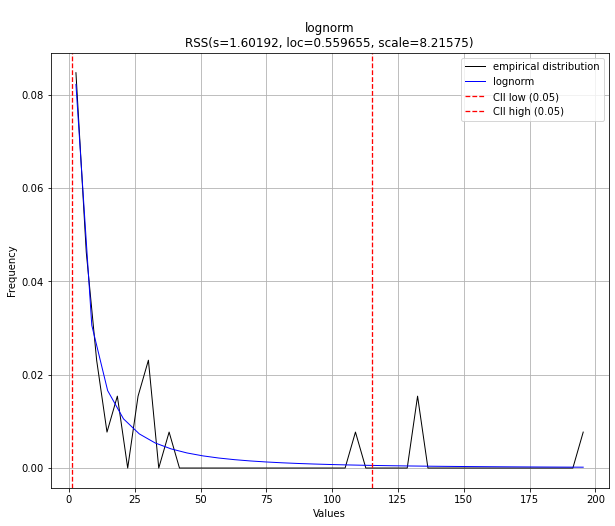

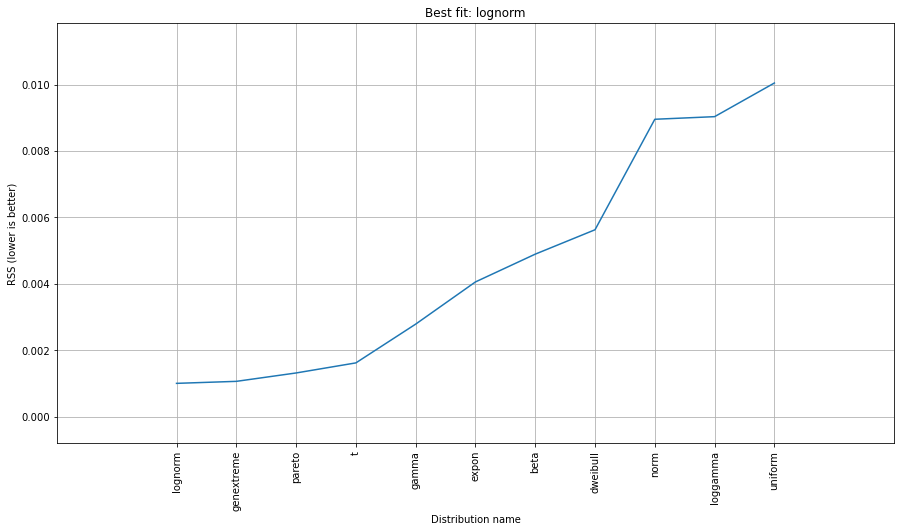

In [41]:
define_analytic(df2.eutro_kcal)

### eutro_protein

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.00370074] [loc=52.772 scale=51.061]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.00256606] [loc=3.384 scale=49.388]
[distfit] >[pareto    ] [0.04 sec] [RSS: 0.00541524] [loc=-0.006 scale=3.390]
[distfit] >[dweibull  ] [0.08 sec] [RSS: 0.00327171] [loc=44.552 scale=32.903]
[distfit] >[t         ] [0.05 sec] [RSS: 0.00304485] [loc=33.769 scale=22.573]
[distfit] >[genextreme] [0.16 sec] [RSS: 0.00276446] [loc=24.010 scale=22.476]
[distfit] >[gamma     ] [0.05 sec] [RSS: 0.00263964] [loc=3.384 scale=52.153]
[distfit] >[lognorm   ] [0.15 sec] [RSS: 0.00396489] [loc=3.384 scale=9.235]
[distfit] >[beta      ] [0.12 sec] [RSS: 0.00290372] [loc=3.384 scale=214.044]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.00399228] [loc=3.384 scale=181.666]
[distfit] >[loggamma  ] [0.07 sec] [RSS: 0.00371723] [loc=-18285.761 scale=2401.742]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..
[distfit] >plot summ

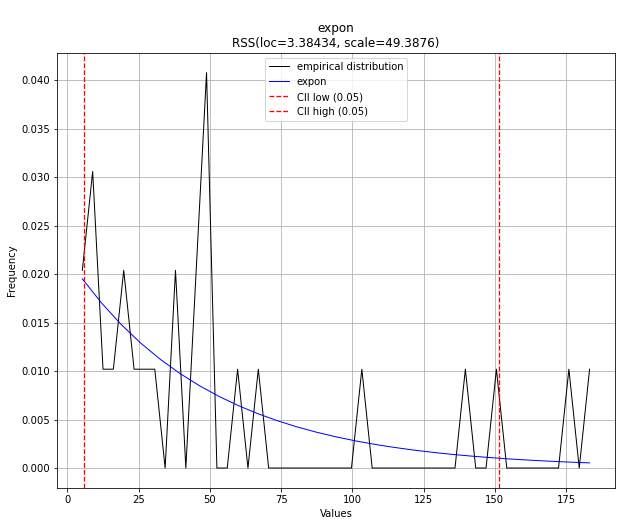

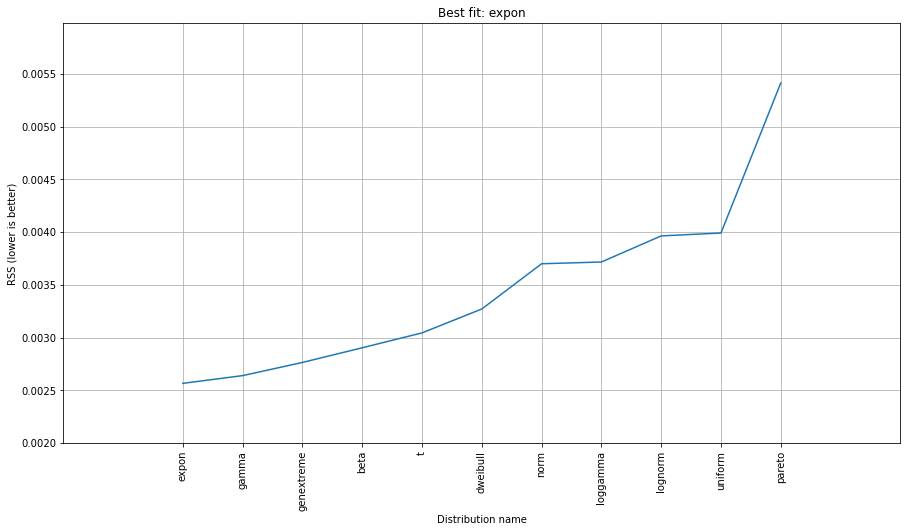

In [42]:
define_analytic(df2.eutro_protein)

### greenhouse_kcal

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.157073] [loc=5.634 scale=10.452]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.0687257] [loc=0.070 scale=5.564]
[distfit] >[pareto    ] [0.11 sec] [RSS: 0.0128174] [loc=-2.243 scale=2.313]
[distfit] >[dweibull  ] [0.04 sec] [RSS: 0.0456502] [loc=0.912 scale=2.035]
[distfit] >[t         ] [0.03 sec] [RSS: 0.0122462] [loc=0.882 scale=0.559]
[distfit] >[genextreme] [0.09 sec] [RSS: 0.011367] [loc=1.078 scale=1.299]
[distfit] >[gamma     ] [0.12 sec] [RSS: 0.0813203] [loc=0.070 scale=20.741]
[distfit] >[lognorm   ] [0.04 sec] [RSS: 0.0121656] [loc=0.028 scale=1.858]
[distfit] >[beta      ] [0.11 sec] [RSS: 0.0383005] [loc=0.070 scale=339.008]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.182011] [loc=0.070 scale=50.877]
[distfit] >[loggamma  ] [0.11 sec] [RSS: 0.159359] [loc=-4873.427 scale=612.197]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..
[distfit] >plot summary..
         distr     s

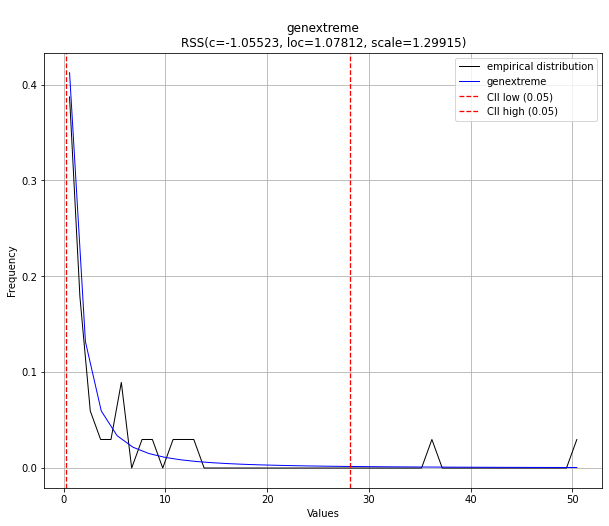

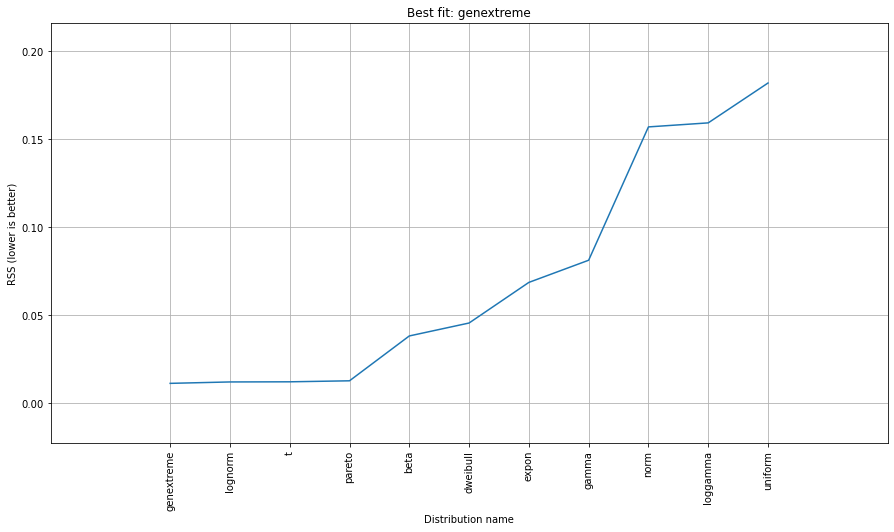

In [43]:
define_analytic(df2.greenhouse_kcal)

### greenhouse_protein

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0199306] [loc=13.525 scale=19.064]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.00748355] [loc=0.263 scale=13.262]
[distfit] >[pareto    ] [0.11 sec] [RSS: 0.00682179] [loc=-24.622 scale=24.885]
[distfit] >[dweibull  ] [0.04 sec] [RSS: 0.00994786] [loc=5.699 scale=8.422]
[distfit] >[t         ] [0.03 sec] [RSS: 0.00984277] [loc=6.363 scale=4.853]
[distfit] >[genextreme] [0.10 sec] [RSS: 0.00750938] [loc=4.753 scale=5.176]
[distfit] >[gamma     ] [0.06 sec] [RSS: 0.0581976] [loc=0.263 scale=1.780]
[distfit] >[lognorm   ] [0.03 sec] [RSS: 0.00716703] [loc=-0.271 scale=7.081]
[distfit] >[beta      ] [0.14 sec] [RSS: 0.0113012] [loc=0.263 scale=10116.203]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.026315] [loc=0.263 scale=93.037]
[distfit] >[loggamma  ] [0.09 sec] [RSS: 0.0203604] [loc=-5754.674 scale=787.332]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..
[distfit] >plot summary..
     

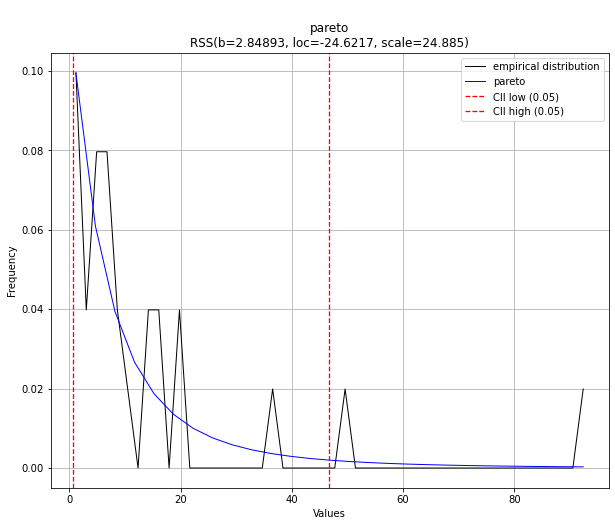

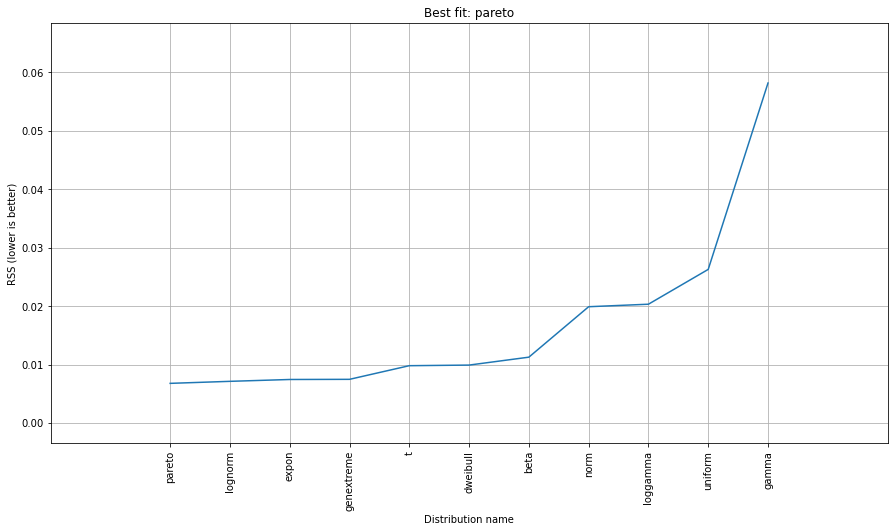

In [44]:
define_analytic(df2.greenhouse_protein)

### land_kcal

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0424768] [loc=12.423 scale=27.916]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.0200739] [loc=0.274 scale=12.149]
[distfit] >[pareto    ] [0.04 sec] [RSS: 0.00601308] [loc=-1.311 scale=1.585]
[distfit] >[dweibull  ] [0.05 sec] [RSS: 0.00992638] [loc=1.202 scale=4.939]
[distfit] >[t         ] [0.03 sec] [RSS: 0.0034938] [loc=2.190 scale=1.453]
[distfit] >[genextreme] [0.08 sec] [RSS: 0.00553049] [loc=1.947 scale=2.212]
[distfit] >[gamma     ] [0.05 sec] [RSS: 0.025649] [loc=0.274 scale=55.698]
[distfit] >[lognorm   ] [0.04 sec] [RSS: 0.00545835] [loc=0.220 scale=3.047]
[distfit] >[beta      ] [0.11 sec] [RSS: 0.00590217] [loc=0.274 scale=1128.552]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.0463927] [loc=0.274 scale=119.217]
[distfit] >[loggamma  ] [0.07 sec] [RSS: 0.0428798] [loc=-9754.875 scale=1297.062]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..
[distfit] >plot summary..
       

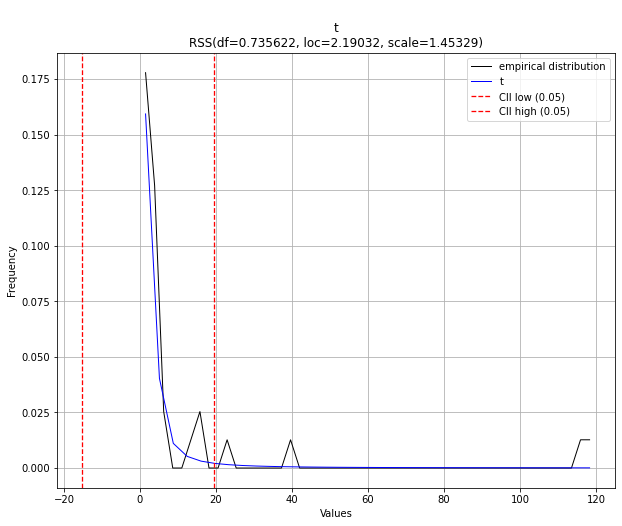

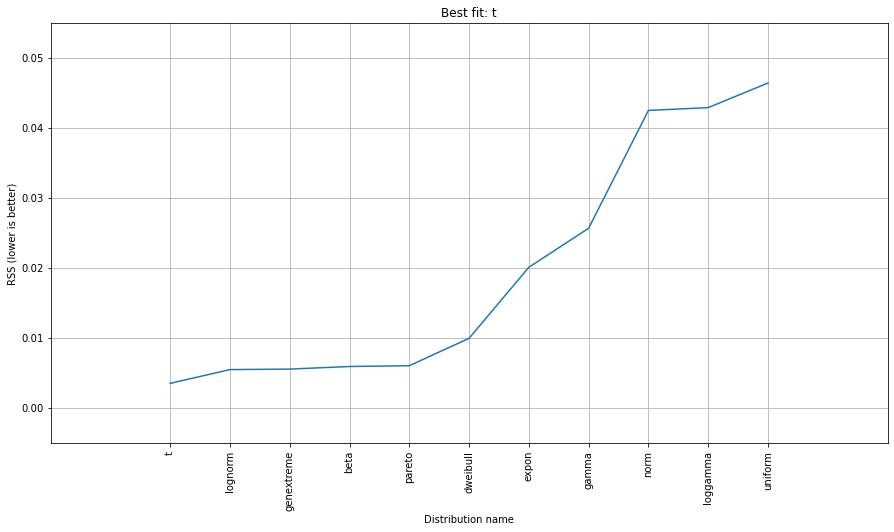

In [45]:
define_analytic(df2.land_kcal)

### land_protein

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0119089] [loc=29.105 scale=48.386]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.00608891] [loc=3.000 scale=26.105]
[distfit] >[pareto    ] [0.04 sec] [RSS: 0.00145098] [loc=-0.009 scale=3.009]
[distfit] >[dweibull  ] [0.08 sec] [RSS: 0.00734386] [loc=5.651 scale=52.710]
[distfit] >[t         ] [0.04 sec] [RSS: 0.0021879] [loc=5.793 scale=3.109]
[distfit] >[genextreme] [0.11 sec] [RSS: 0.00150107] [loc=5.810 scale=4.724]
[distfit] >[gamma     ] [0.08 sec] [RSS: 0.0039246] [loc=3.000 scale=91.296]
[distfit] >[lognorm   ] [0.06 sec] [RSS: 0.00148405] [loc=2.955 scale=5.859]
[distfit] >[beta      ] [0.07 sec] [RSS: 0.00874442] [loc=2.999 scale=181.813]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.0129079] [loc=3.000 scale=181.813]
[distfit] >[loggamma  ] [0.07 sec] [RSS: 0.0120416] [loc=-15945.016 scale=2147.887]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..
[distfit] >plot summary..
    

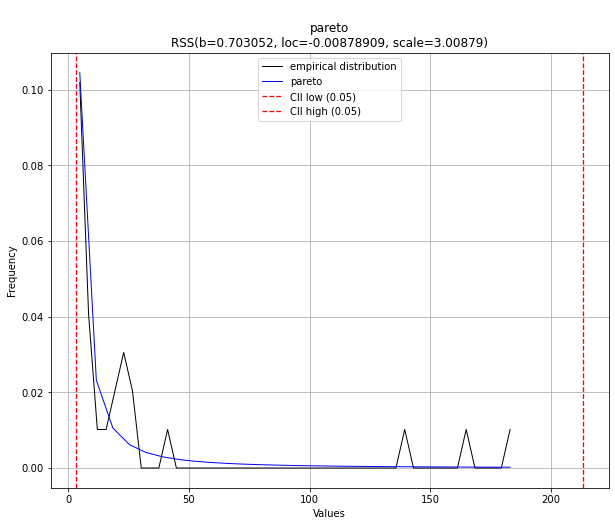

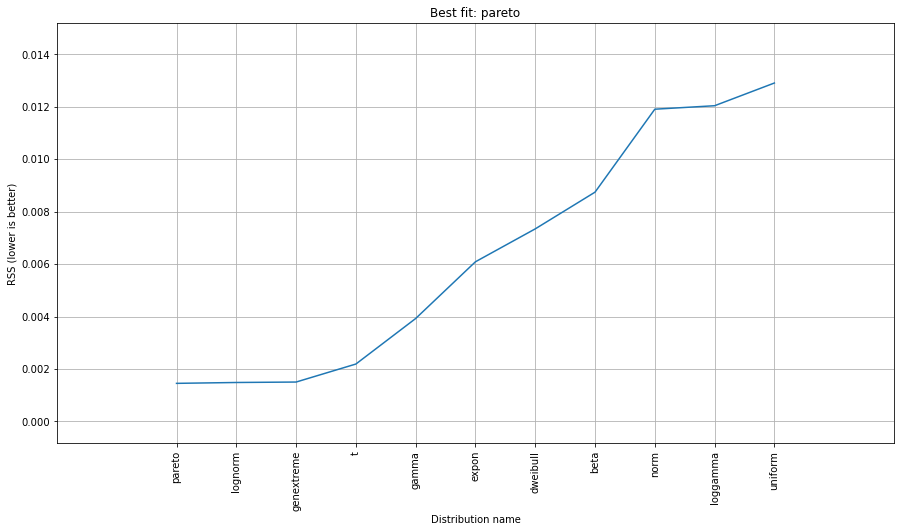

In [46]:
define_analytic(df2.land_protein)

### water_kcal

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 4.36911e-08] [loc=17380.575 scale=15959.253]
[distfit] >[expon     ] [0.00 sec] [RSS: 3.05639e-08] [loc=4.095 scale=17376.480]
[distfit] >[pareto    ] [0.02 sec] [RSS: 3.93162e-08] [loc=-0.000 scale=4.095]
[distfit] >[dweibull  ] [0.03 sec] [RSS: 4.22757e-08] [loc=14256.949 scale=14583.629]
[distfit] >[t         ] [0.08 sec] [RSS: 4.36916e-08] [loc=17381.828 scale=15959.695]
[distfit] >[genextreme] [0.24 sec] [RSS: 4.10913e-08] [loc=7.430 scale=21.052]
[distfit] >[gamma     ] [0.09 sec] [RSS: 2.89244e-08] [loc=4.095 scale=59377.403]
[distfit] >[lognorm   ] [0.12 sec] [RSS: 4.07089e-08] [loc=4.095 scale=10.844]
[distfit] >[beta      ] [0.11 sec] [RSS: 2.90887e-08] [loc=4.095 scale=62464.685]
[distfit] >[uniform   ] [0.00 sec] [RSS: 4.04326e-08] [loc=4.095 scale=49731.787]
[distfit] >[loggamma  ] [0.07 sec] [RSS: 4.36061e-08] [loc=-5044470.683 scale=678463.825]
[distfit] >Compute confidence interval [paramet

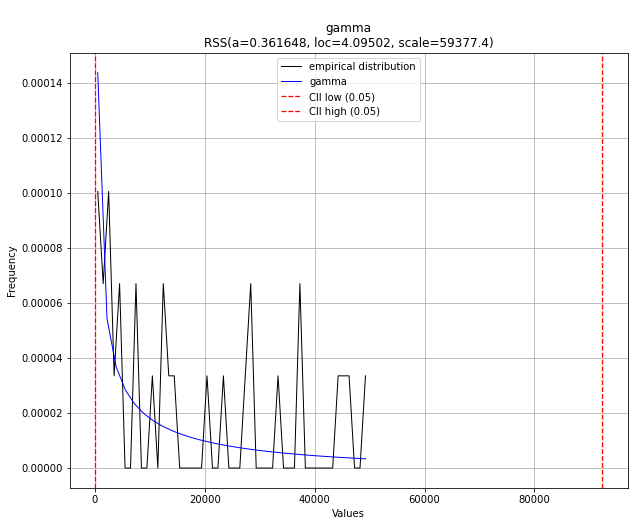

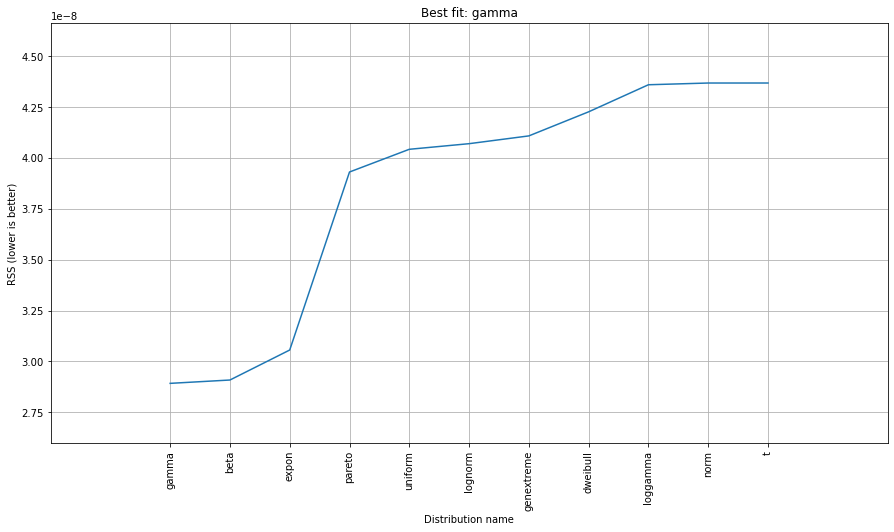

In [47]:
define_analytic(df2.water_kcal)

### water_protein

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 1.49504e-09] [loc=59196.439 scale=88181.845]
[distfit] >[expon     ] [0.00 sec] [RSS: 7.90702e-10] [loc=421.250 scale=58775.189]
[distfit] >[pareto    ] [0.03 sec] [RSS: 1.04226e-09] [loc=-0.592 scale=421.842]
[distfit] >[dweibull  ] [0.05 sec] [RSS: 5.41143e-10] [loc=12577.948 scale=35889.913]
[distfit] >[t         ] [0.08 sec] [RSS: 6.04741e-10] [loc=14212.003 scale=10320.180]
[distfit] >[genextreme] [0.24 sec] [RSS: 1.59112e-09] [loc=422.655 scale=8.886]
[distfit] >[gamma     ] [0.06 sec] [RSS: 2.0579e-09] [loc=-675682963.313 scale=108886.657]
[distfit] >[lognorm   ] [0.05 sec] [RSS: 6.07847e-10] [loc=-1098.053 scale=29181.152]
[distfit] >[beta      ] [0.10 sec] [RSS: 6.87468e-10] [loc=421.250 scale=7441243.966]
[distfit] >[uniform   ] [0.00 sec] [RSS: 1.79966e-09] [loc=421.250 scale=431198.750]
[distfit] >[loggamma  ] [0.07 sec] [RSS: 1.51055e-09] [loc=-33598462.347 scale=4365586.371]
[distfit] >Comput

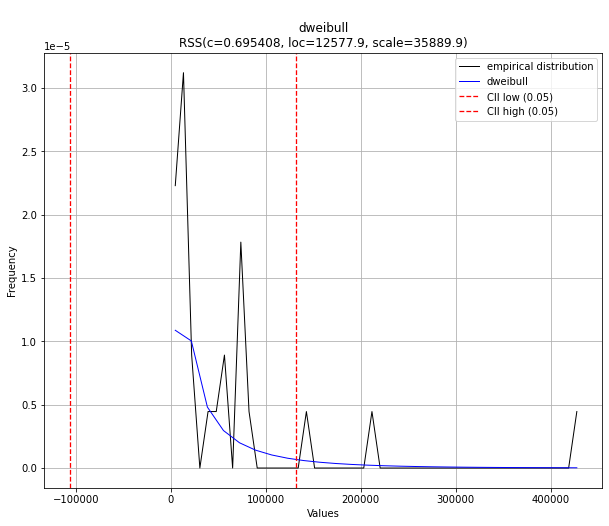

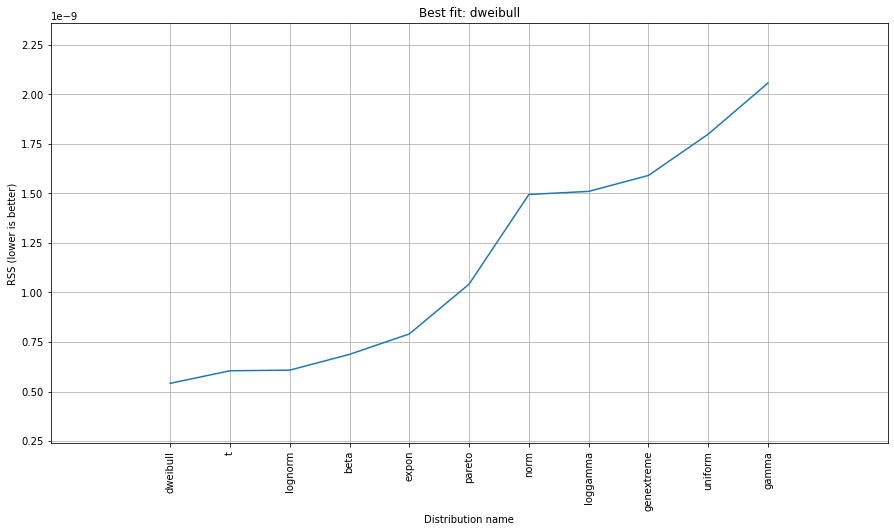

In [48]:
define_analytic(df2.water_protein)

## Scatterplots

### eutro_kcal versus eutro_protein

<AxesSubplot:xlabel='eutro_kcal', ylabel='eutro_protein'>

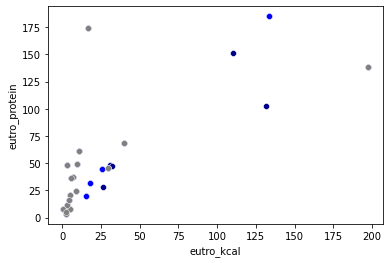

In [49]:
sns.scatterplot(data=df2, x="eutro_kcal", y="eutro_protein", color = "darkblue")
sns.scatterplot(data=veg, x="eutro_kcal", y="eutro_protein", color = "blue")
sns.scatterplot(data=vegan, x="eutro_kcal", y="eutro_protein", color = "grey")

### greenhouse_kcal versus greenhouse_protein

<AxesSubplot:xlabel='greenhouse_kcal', ylabel='greenhouse_protein'>

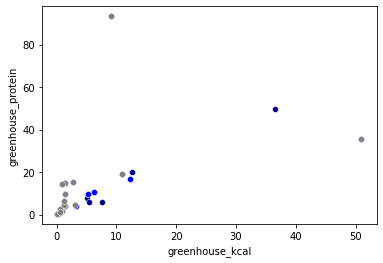

In [50]:
sns.scatterplot(data=df2, x="greenhouse_kcal", y="greenhouse_protein", color = "darkblue")
sns.scatterplot(data=veg, x="greenhouse_kcal", y="greenhouse_protein", color = "blue")
sns.scatterplot(data=vegan, x="greenhouse_kcal", y="greenhouse_protein", color = "grey")

### land_kcal versus land_protein

<AxesSubplot:xlabel='land_kcal', ylabel='land_protein'>

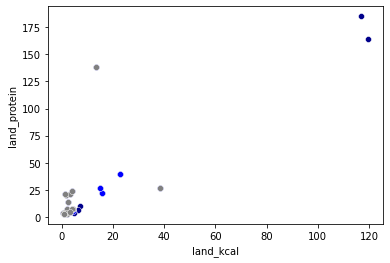

In [51]:
sns.scatterplot(data=df2, x="land_kcal", y="land_protein", color = "darkblue")
sns.scatterplot(data=veg, x="land_kcal", y="land_protein", color = "blue")
sns.scatterplot(data=vegan, x="land_kcal", y="land_protein", color = "grey")

### water_kcal versus water_protein

<AxesSubplot:xlabel='water_kcal', ylabel='water_protein'>

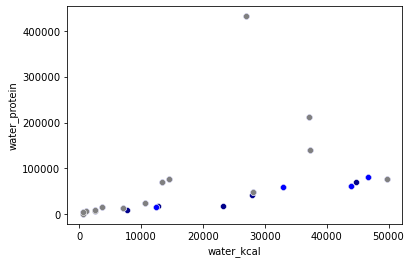

In [52]:
sns.scatterplot(data=df2, x="water_kcal", y="water_protein", color = "darkblue")
sns.scatterplot(data=veg, x="water_kcal", y="water_protein", color = "blue")
sns.scatterplot(data=vegan, x="water_kcal", y="water_protein", color = "grey")

Since I am graphing the same environmental impact, but with two different measurements, against one another I had assumed there would be a great sense of linearity. These plots really show the extremity of the outliers, and how far from the rest of the data they are. For the sake of pure statistical analysis, these outliers should aboslutely be removed because it really shows how much these extreme values skew the distribution- however, there is no reason to believe that these outliers are mistakes in data collection. In fact, they are important in the data as a whole. 

## Hypothesis test

### total_em

In [53]:
# vegetarian less total emissions than animal-based
ss.mannwhitneyu(x = veg.total_em, y = df2.total_em, alternative = "less")

MannwhitneyuResult(statistic=705.5, pvalue=0.1935051341490287)

In [54]:
# vegan less total emissions than vegetarian
ss.mannwhitneyu(x = vegan.total_em, y = veg.total_em, alternative = "less")

MannwhitneyuResult(statistic=558.5, pvalue=0.2718039981752386)

In [55]:
# vegan less total emissions than animal-based
ss.mannwhitneyu(x = vegan.total_em, y = df2.total_em, alternative = "less")

MannwhitneyuResult(statistic=571.5, pvalue=0.07441556070492732)

### eutro_kcal

In [56]:
# variables without Na's
veg_eutro_kcal = [item for item in veg.eutro_kcal if not(math.isnan(item)) == True]
df2_eutro_kcal = [item for item in df2.eutro_kcal if not(math.isnan(item)) == True]
vegan_eutro_kcal = [item for item in vegan.eutro_kcal if not(math.isnan(item)) == True]

In [57]:
# vegetarian less eutrophying emissions per 1000kcal than animal-based
ss.mannwhitneyu(x = veg_eutro_kcal, y = df2_eutro_kcal, alternative = "less")

MannwhitneyuResult(statistic=406.0, pvalue=0.21082861788431284)

In [58]:
# vegan less eutrophying emissions per 1000kcal than vegetarian
ss.mannwhitneyu(x = vegan_eutro_kcal, y = veg_eutro_kcal, alternative = "less")

MannwhitneyuResult(statistic=299.0, pvalue=0.25132626054704515)

In [59]:
# vegan less eutrophying emissions per 1000kcal than animal-based
ss.mannwhitneyu(x = vegan_eutro_kcal, y = df2_eutro_kcal, alternative = "less")

MannwhitneyuResult(statistic=308.0, pvalue=0.07856548215397303)

### eutro_protein

In [60]:
# variables without Na's
veg_eutro_protein = [item for item in veg.eutro_protein if not(math.isnan(item)) == True]
df2_eutro_protein = [item for item in df2.eutro_protein if not(math.isnan(item)) == True]
vegan_eutro_protein = [item for item in vegan.eutro_protein if not(math.isnan(item)) == True]

In [61]:
# vegetarian less eutrophying emissions per 100g protein than animal-based
ss.mannwhitneyu(x = veg_eutro_protein, y = df2_eutro_protein, alternative = "less")

MannwhitneyuResult(statistic=272.0, pvalue=0.3110963363416528)

In [62]:
# vegan less eutrophying emissions per 100g protein than vegetarian
ss.mannwhitneyu(x = vegan_eutro_protein, y = veg_eutro_protein, alternative = "less")

MannwhitneyuResult(statistic=189.0, pvalue=0.4085488642097164)

In [63]:
# vegan less eutrophying emissions per 100g protein than animal-based
ss.mannwhitneyu(x = vegan_eutro_protein, y = df2_eutro_protein, alternative = "less")

MannwhitneyuResult(statistic=212.0, pvalue=0.23976723529803945)

### greenhouse_kcal

In [64]:
# variables without Na's
veg_greenhouse_kcal = [item for item in veg.greenhouse_kcal if not(math.isnan(item)) == True]
df2_greenhouse_kcal = [item for item in df2.greenhouse_kcal if not(math.isnan(item)) == True]
vegan_greenhouse_kcal = [item for item in vegan.greenhouse_kcal if not(math.isnan(item)) == True]

In [65]:
# vegetarian less greenhouse emissions per 1000kcal than animal-based
ss.mannwhitneyu(x = veg_greenhouse_kcal, y = df2_greenhouse_kcal, alternative = "less")

MannwhitneyuResult(statistic=409.0, pvalue=0.2235931237125317)

In [66]:
# vegan less greenhouse emissions per 1000kcal than vegetarian
ss.mannwhitneyu(x = vegan_greenhouse_kcal, y = veg_greenhouse_kcal, alternative = "less")

MannwhitneyuResult(statistic=298.0, pvalue=0.2455101212618333)

In [67]:
# vegan less greenhouse emissions per 1000kcal than animal-based
ss.mannwhitneyu(x = vegan_greenhouse_kcal, y = df2_greenhouse_kcal, alternative = "less")

MannwhitneyuResult(statistic=309.0, pvalue=0.08096378575893709)

### greenhouse_protein

In [68]:
# variables without NA's
veg_greenhouse_protein = [item for item in veg.greenhouse_protein if not(math.isnan(item)) == True]
df2_greenhouse_protein = [item for item in df2.greenhouse_protein if not(math.isnan(item)) == True]
vegan_greenhouse_protein = [item for item in vegan.greenhouse_protein if not(math.isnan(item)) == True]

In [69]:
# vegetarian less greenhouse emissions per 100g protein than animal-based
ss.mannwhitneyu(x = veg_greenhouse_protein, y = df2_greenhouse_protein, alternative = "less")

MannwhitneyuResult(statistic=279.0, pvalue=0.3624338230013679)

In [70]:
# vegan less greenhouse emissions per 100g protein than vegetarian
ss.mannwhitneyu(x = vegan_greenhouse_protein, y = veg_greenhouse_protein, alternative = "less")

MannwhitneyuResult(statistic=189.0, pvalue=0.4085488642097164)

In [71]:
# vegan less greenhouse emissions per 100g protein than animal-based
ss.mannwhitneyu(x = vegan_greenhouse_protein, y = df2_greenhouse_protein, alternative = "less")

MannwhitneyuResult(statistic=217.0, pvalue=0.27721283362388954)

### land_kcal

In [72]:
# variables without Na's
veg_land_kcal = [item for item in veg.land_kcal if not(math.isnan(item)) == True]
df2_land_kcal = [item for item in df2.land_kcal if not(math.isnan(item)) == True]
vegan_land_kcal = [item for item in vegan.land_kcal if not(math.isnan(item)) == True]

In [73]:
# vegetarian less use of land per 1000kcal than animal-based
ss.mannwhitneyu(x = veg_land_kcal, y = df2_land_kcal, alternative = "less")

MannwhitneyuResult(statistic=407.0, pvalue=0.21503523567746058)

In [74]:
# vegan less use of land per 1000kcal than vegetarian
ss.mannwhitneyu(x = vegan_land_kcal, y = veg_land_kcal, alternative = "less")

MannwhitneyuResult(statistic=294.0, pvalue=0.2229861444937108)

In [75]:
# vegan less use of land per 1000kcal than animal-based
ss.mannwhitneyu(x = vegan_land_kcal, y = df2_land_kcal, alternative = "less")

MannwhitneyuResult(statistic=300.0, pvalue=0.06127734021854017)

### land_protein

In [76]:
# variables without Na's
veg_land_protein = [item for item in veg.land_protein if not(math.isnan(item)) == True]
df2_land_protein = [item for item in df2.land_protein if not(math.isnan(item)) == True]
vegan_land_protein = [item for item in vegan.land_protein if not(math.isnan(item)) == True]

In [77]:
# vegetarian less use of land per 100g protein than animal-based
ss.mannwhitneyu(x = veg_land_protein, y = df2_land_protein, alternative = "less")

MannwhitneyuResult(statistic=283.0, pvalue=0.3929983926043856)

In [78]:
# vegan less use of land per 100g protein than vegetarian
ss.mannwhitneyu(x = vegan_land_protein, y = veg_land_protein, alternative = "less")

MannwhitneyuResult(statistic=178.0, pvalue=0.2978541615314826)

In [79]:
# vegan less use of land per 100g protein than animal-based
ss.mannwhitneyu(x = vegan_land_protein, y = df2_land_protein, alternative = "less")

MannwhitneyuResult(statistic=209.0, pvalue=0.21869812209072598)

### water_kcal

In [80]:
# variables without Na's
veg_water_kcal = [item for item in veg.water_kcal if not(math.isnan(item)) == True]
df2_water_kcal = [item for item in df2.water_kcal if not(math.isnan(item)) == True]
vegan_water_kcal = [item for item in vegan.water_kcal if not(math.isnan(item)) == True]

In [81]:
# vegetarian less use of water per 1000kcal than animal-based
ss.mannwhitneyu(x = veg_water_kcal, y = df2_water_kcal, alternative = "less")

MannwhitneyuResult(statistic=353.5, pvalue=0.36124798828098603)

In [82]:
# vegan less use of water per 1000kcal than vegetarian
ss.mannwhitneyu(x = vegan_water_kcal, y = veg_water_kcal, alternative = "less")

MannwhitneyuResult(statistic=233.5, pvalue=0.264704078995766)

In [83]:
# vegan less use of water per 1000kcal than animal-based
ss.mannwhitneyu(x = vegan_water_kcal, y = df2_water_kcal, alternative = "less")

MannwhitneyuResult(statistic=260.5, pvalue=0.15056900842093546)

### water_protein

In [84]:
# variables without Na's
veg_water_protein = [item for item in veg.water_protein if not(math.isnan(item)) == True]
df2_water_protein = [item for item in df2.water_protein if not(math.isnan(item)) == True]
vegan_water_protein = [item for item in vegan.water_protein if not(math.isnan(item)) == True]

In [85]:
# vegetarian less use of water per 100g protein than animal-based
ss.mannwhitneyu(x = veg_water_protein, y = df2_water_protein, alternative = "less")

MannwhitneyuResult(statistic=275.5, pvalue=0.525607681182107)

In [86]:
# vegan less use of water per 100g protein than vegetarian
ss.mannwhitneyu(x = vegan_water_protein, y = veg_water_protein, alternative = "less")

MannwhitneyuResult(statistic=167.5, pvalue=0.37883402069503974)

In [87]:
# vegan less use of water per 100g protein than animal-based
ss.mannwhitneyu(x = vegan_water_protein, y = df2_water_protein, alternative = "less")

MannwhitneyuResult(statistic=208.5, pvalue=0.3827475718105846)

The idea here was to run hypothesis tests across the board of the varaibles selected. Under my own initial assumption that plant-based diets are better for the environment than animal-based diets, I had wished to complicate this idea by trying to see if they are better across the board or only better across a few environmental impact measures- for example, a vegetarian diet might produce less greenhouse gas emissions during production than an animal-based diet (it does not) but it does not make a difference in the amount of water used to produce the food (which is technically true). 

I will admit that I did not originally compare vegan food products to animal-based products (I had originally only compared vegetarian to animal-based and vegan to vegetarian which makes very little sense on why it was left out based on the research question). That being said, the addition of the hypothesis tests that see if vegan food products have less of an environmental impact than animal-based products did not result in any significant results at the 95% level. There were a few instances (total_em, eutro_kcal, greenhouse_kcal, and land_kcal) that would be significant at a 90% level; but since I had intended to use the 95% level from the beginning, it is still true that there is no reason to believe that diet has an environmental impact in any way, based on this data set. In all of the tests, the alternative hypothesis is rejected in favor of the null hypothesis: there is no signifcant difference in environmental impact based on food production. 

## Regression Analysis

In [88]:
results = smf.ols("total_em ~ land_kcal + eutro_kcal + water_kcal + greenhouse_kcal", data = df2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               total_em   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     21.22
Date:                Wed, 16 Nov 2022   Prob (F-statistic):           9.78e-08
Time:                        20:41:58   Log-Likelihood:                -94.748
No. Observations:                  30   AIC:                             199.5
Df Residuals:                      25   BIC:                             206.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.5255      1.833      1.377      0.181      -1.251       6.302
land_kcal           0.3146      0.060      5.283      0.000       0.192       0.437
eutro_kcal          0.0474      0.052      0.903      0.375      -0.061       0.155
water_kcal      -5.073e-05   8.25e-05     -0.615      0.544      -0.000       0.000
greenhouse_kcal     0.0424      0.277      0.153      0.880      -0.529       0.613
==============================================================================
Omnibus:                        3.804   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.149   Jarque-Bera (JB):                2.387
Skew:                           0.406   Prob(JB):                        0.303
Kurtosis:                       4.118   Cond. No.                     3.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Summary

### Statistical/Hypothetical Question

This study aimed to explore the relationship between diet and the environment. It was meant to test the claim that pant-based diets are better for the environment than traditional ones with animal-products. The different diets that were tested was a vegetarian diet that includes some animal products (such as eggs, dairy, cheese, honey) but no meant or seafood, a vegan diet that excludes all animal products, and a traditional “animal-based” diet that excludes none of the food products. 

### Outcome of EDA

From this data set, it is impossible to reject any of the null hypotheses. Across every environmental impact that was measured, there was no evidence that a plant-based diet (either vegetarian or vegan) was any better for the environment than the animal-based diet. This was concluded based on a non-parametric test (Mann Whitney U test) because no variable was normally distributed. 

### What was missed during the analysis

I feel like I could have focused more on the relationship between the kcal and protein variable pairs (see Scatterplots section above) to see what kind of information could have been gained from understanding the base of those relationships and trends. 

### Variables that could have helped with analysis

I think it would have been interesting to look at the emissions that each food product emits due to transportation during production (Transport). In that vein, looking at the emissions at each step of the production process and how they contributed to the final total might have been interesting, as some steps might have contributed more for one of the diet scenarios than the others. 

### Incorrect assumptions

I really ran with the idea assumption that plant-based diets are better for the environment than traditional animal-based diets, as that really shaped my questions and the analysis performed. If I were to step back and look at the data more closely at the beginning, I might have spent more time doing some simple EDA with all the variables (as I did choose the variables ahead of time based on my research question and initial assumptions). 

### Challenges

I think the nature of the data set that I chose really became a problem for me. When I first chose this data set at the beginning of this term, I was not very confident in my abilities nor was I very observant when I was initially looking at the data. Because of the size, I do not think my findings (if they were to even be statistically significant within the scope of the study) would be very implicative of the world at large. I also really struggled with determining the equation for the regression analysis- it took me some time to decide what to use for the response variable, as none of the variables suggested a natural linear relationship that would be meaningful. I also did not spend a lot of time looking at the linear relationships between the environmental factors and their two different measurements (see Scatterplots section above), and I think that could have provided interesting information that I did not take the time to fully explore or understand. 